In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import onnxruntime as rt
from tqdm import tqdm

In [15]:
# constants and parameters definition
data_path = '../data/300k_dataset.csv'
model1_path = '../Group 9/model_1.onnx'
model2_path = '../Group 9/model_2.onnx'

In [16]:
def calculate_distribution(preds):
    return np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)


def differential_testing_by_age_group(
        model1_path, model2_path, data_address, age_column="persoon_leeftijd_bij_onderzoek"
):

    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1).astype(np.float32)

    session1 = rt.InferenceSession(model1_path)
    session2 = rt.InferenceSession(model2_path)
    input_name1 = session1.get_inputs()[0].name
    input_name2 = session2.get_inputs()[0].name

    age_bins = [(18, 35), (35, 55), (55, 67)]
    results = []

    for start, end in age_bins:
        print(f"Processing age group {start}-{end}...")

        age_mask = (data[age_column] >= start) & (data[age_column] <= end)
        sub_X_age = X[age_mask]

        if len(sub_X_age) == 0:
            print(f"No samples found in age group {start}-{end}, skipping.")
            continue

        preds_model1 = session1.run(None, {input_name1: sub_X_age.values})[0]
        preds_model2 = session2.run(None, {input_name2: sub_X_age.values})[0]

        if preds_model1.ndim > 1:
            preds_model1 = np.argmax(preds_model1, axis=1)
            preds_model2 = np.argmax(preds_model2, axis=1)

        dist_model1 = calculate_distribution(preds_model1)
        dist_model2 = calculate_distribution(preds_model2)


        preds_all_model1 = session1.run(None, {input_name1: X.values})[0]
        preds_all_model2 = session2.run(None, {input_name2: X.values})[0]

        if preds_all_model1.ndim > 1:
            preds_all_model1 = np.argmax(preds_all_model1, axis=1)
            preds_all_model2 = np.argmax(preds_all_model2, axis=1)

        overall_dist_model1 = calculate_distribution(preds_all_model1)
        overall_dist_model2 = calculate_distribution(preds_all_model2)

        kl_model1 = entropy(dist_model1, overall_dist_model1)
        kl_model2 = entropy(dist_model2, overall_dist_model2)
        kl_difference = kl_model1 - kl_model2

        results.append([f"{start}-{end}", kl_model1, kl_model2, kl_difference])
        print(f"Age group {start}-{end} KL Divergence - Model1: {kl_model1:.4f}, Model2: {kl_model2:.4f}, Difference: {kl_difference:.4f}")

    return results

def visualize_kl_comparison_heatmap(results):
    result_df = pd.DataFrame(results, columns=["Age Group", "KL Model 1", "KL Model 2", "KL Difference"])
    result_df = result_df.set_index("Age Group")

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        result_df[["KL Difference"]].T,
        annot=True,
        fmt=".4f",
        center=0,
        annot_kws={"size": 12}
    )
    plt.title("KL Divergence Difference by Age Group", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


Processing age group 18-35...
Age group 18-35 KL Divergence - Model1: 0.0501, Model2: 0.2505, Difference: -0.2004
Processing age group 35-55...
Age group 35-55 KL Divergence - Model1: 0.0007, Model2: 0.0005, Difference: 0.0002
Processing age group 55-67...
Age group 55-67 KL Divergence - Model1: 0.0032, Model2: 0.0716, Difference: -0.0684


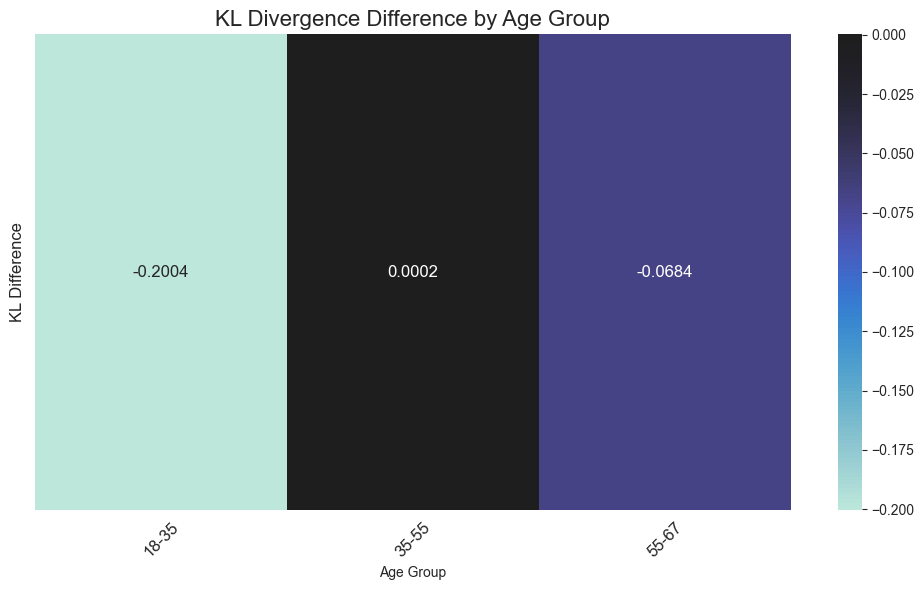

In [17]:
results = differential_testing_by_age_group(model1_path, model2_path, data_path)
visualize_kl_comparison_heatmap(results)


In [18]:

def calculate_distribution(preds):
    return np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)


def differential_testing_by_gender(
        model1_path, model2_path, data_address, gender_column="persoon_geslacht_vrouw"
):

    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1).astype(np.float32)

    session1 = rt.InferenceSession(model1_path)
    session2 = rt.InferenceSession(model2_path)
    input_name1 = session1.get_inputs()[0].name
    input_name2 = session2.get_inputs()[0].name

    genders = data[gender_column].unique()
    results = []

    for gender in genders:
        print(f"Processing gender: {gender}...")

        gender_mask = (data[gender_column] == gender)
        sub_X_gender = X[gender_mask]

        if len(sub_X_gender) == 0:
            print(f"No samples found for gender {gender}, skipping.")
            continue


        preds_model1 = session1.run(None, {input_name1: sub_X_gender.values})[0]
        preds_model2 = session2.run(None, {input_name2: sub_X_gender.values})[0]

        if preds_model1.ndim > 1:
            preds_model1 = np.argmax(preds_model1, axis=1)
            preds_model2 = np.argmax(preds_model2, axis=1)


        dist_model1 = calculate_distribution(preds_model1)
        dist_model2 = calculate_distribution(preds_model2)

        preds_all_model1 = session1.run(None, {input_name1: X.values})[0]
        preds_all_model2 = session2.run(None, {input_name2: X.values})[0]

        if preds_all_model1.ndim > 1:
            preds_all_model1 = np.argmax(preds_all_model1, axis=1)
            preds_all_model2 = np.argmax(preds_all_model2, axis=1)

        overall_dist_model1 = calculate_distribution(preds_all_model1)
        overall_dist_model2 = calculate_distribution(preds_all_model2)


        kl_model1 = entropy(dist_model1, overall_dist_model1)
        kl_model2 = entropy(dist_model2, overall_dist_model2)
        kl_difference = kl_model1 - kl_model2

        results.append([f"{gender}", kl_model1, kl_model2, kl_difference])
        print(f"Gender {gender} KL Divergence - Model1: {kl_model1:.4f}, Model2: {kl_model2:.4f}, Difference: {kl_difference:.4f}")

    return results

def visualize_gender_kl_comparison_heatmap(results):
    result_df = pd.DataFrame(results, columns=["Gender", "KL Model 1", "KL Model 2", "KL Difference"])
    result_df = result_df.set_index("Gender")

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        result_df[["KL Difference"]].T,
        annot=True,
        fmt=".4f",
        center=0,
        annot_kws={"size": 12}
    )
    plt.title("KL Divergence Difference by Gender", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


Processing gender: 0...
Gender 0 KL Divergence - Model1: 0.0001, Model2: 0.0046, Difference: -0.0045
Processing gender: 1...
Gender 1 KL Divergence - Model1: 0.0001, Model2: 0.0046, Difference: -0.0045


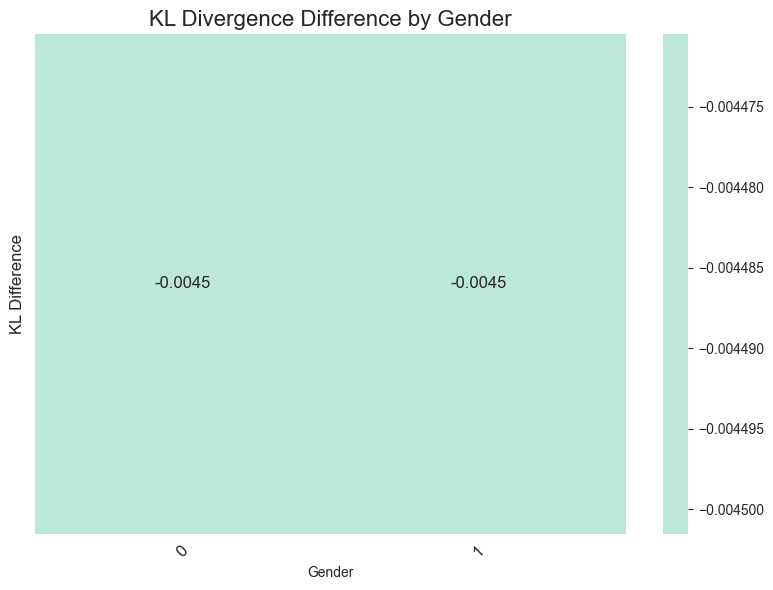

In [19]:
results = differential_testing_by_gender(model1_path, model2_path, data_path)
visualize_gender_kl_comparison_heatmap(results)


In [20]:
from scipy.stats import entropy
import numpy as np
import pandas as pd
import onnxruntime as rt
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_distribution(preds):
    return np.bincount(preds, minlength=np.max(preds) + 1) / len(preds)

def differential_testing_by_days(
        model1_path, model2_path, data_address, days_column="persoonlijke_eigenschappen_dagen_sinds_taaleis", bins=5
):

    data = pd.read_csv(data_address)
    X = data.drop(['checked', 'Ja', 'Nee'], axis=1).astype(np.float32)

    session1 = rt.InferenceSession(model1_path)
    session2 = rt.InferenceSession(model2_path)
    input_name1 = session1.get_inputs()[0].name
    input_name2 = session2.get_inputs()[0].name

    data['days_bins'] = pd.qcut(data[days_column], bins, duplicates='drop')

    bin_categories = data['days_bins'].unique()
    results = []

    for bin_range in bin_categories:
        print(f"Processing days bin: {bin_range}...")

        bin_mask = (data['days_bins'] == bin_range)
        sub_X_bin = X[bin_mask]

        if len(sub_X_bin) == 0:
            print(f"No samples found for days bin {bin_range}, skipping.")
            continue

        preds_model1 = session1.run(None, {input_name1: sub_X_bin.values})[0]
        preds_model2 = session2.run(None, {input_name2: sub_X_bin.values})[0]

        if preds_model1.ndim > 1:
            preds_model1 = np.argmax(preds_model1, axis=1)
            preds_model2 = np.argmax(preds_model2, axis=1)

        dist_model1 = calculate_distribution(preds_model1)
        dist_model2 = calculate_distribution(preds_model2)

        preds_all_model1 = session1.run(None, {input_name1: X.values})[0]
        preds_all_model2 = session2.run(None, {input_name2: X.values})[0]

        if preds_all_model1.ndim > 1:
            preds_all_model1 = np.argmax(preds_all_model1, axis=1)
            preds_all_model2 = np.argmax(preds_all_model2, axis=1)

        overall_dist_model1 = calculate_distribution(preds_all_model1)
        overall_dist_model2 = calculate_distribution(preds_all_model2)

        # 计算 KL 散度
        kl_model1 = entropy(dist_model1, overall_dist_model1)
        kl_model2 = entropy(dist_model2, overall_dist_model2)
        kl_difference = kl_model1 - kl_model2

        results.append([f"{bin_range}", kl_model1, kl_model2, kl_difference])
        print(f"Days bin {bin_range} KL Divergence - Model1: {kl_model1:.4f}, Model2: {kl_model2:.4f}, Difference: {kl_difference:.4f}")

    return results

def visualize_kl_comparison_heatmap(results):
    result_df = pd.DataFrame(results, columns=["Days Bin", "KL Model 1", "KL Model 2", "KL Difference"])
    result_df = result_df.set_index("Days Bin")

    plt.figure(figsize=(14, 6))
    sns.heatmap(
        result_df[["KL Difference"]].T,
        annot=True,
        fmt=".4f",
        center=0,
        annot_kws={"size": 12}
    )
    plt.title("KL Divergence Difference by Days Since Language Requirement", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


Processing days bin: (159.0, 304.0]...
Days bin (159.0, 304.0] KL Divergence - Model1: 0.0004, Model2: 0.0137, Difference: -0.0132
Processing days bin: (304.0, 467.0]...
Days bin (304.0, 467.0] KL Divergence - Model1: 0.0000, Model2: 0.0027, Difference: -0.0027
Processing days bin: (688.0, 1785.0]...
Days bin (688.0, 1785.0] KL Divergence - Model1: 0.0030, Model2: 0.1081, Difference: -0.1051
Processing days bin: (467.0, 688.0]...
Days bin (467.0, 688.0] KL Divergence - Model1: 0.0006, Model2: 0.0424, Difference: -0.0418
Processing days bin: (-0.001, 159.0]...
Days bin (-0.001, 159.0] KL Divergence - Model1: 0.0024, Model2: 0.1022, Difference: -0.0998


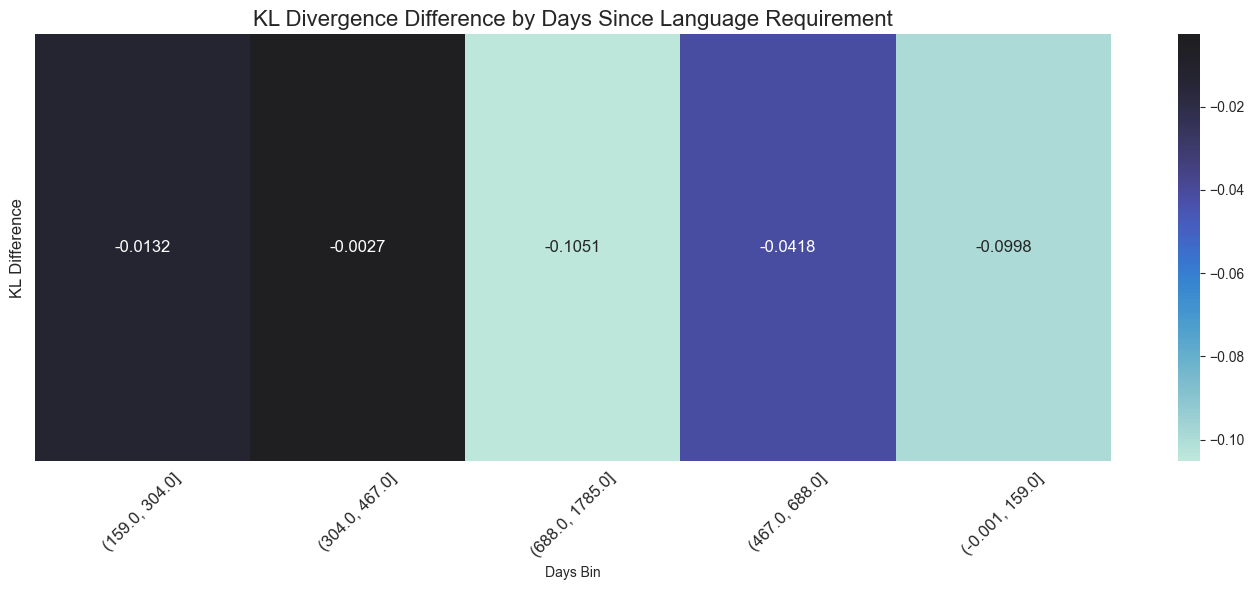

In [21]:
results = differential_testing_by_days("../Group 9/model_1.onnx", "../Group 9/model_2.onnx", "../data/300k_dataset.csv")
visualize_kl_comparison_heatmap(results)


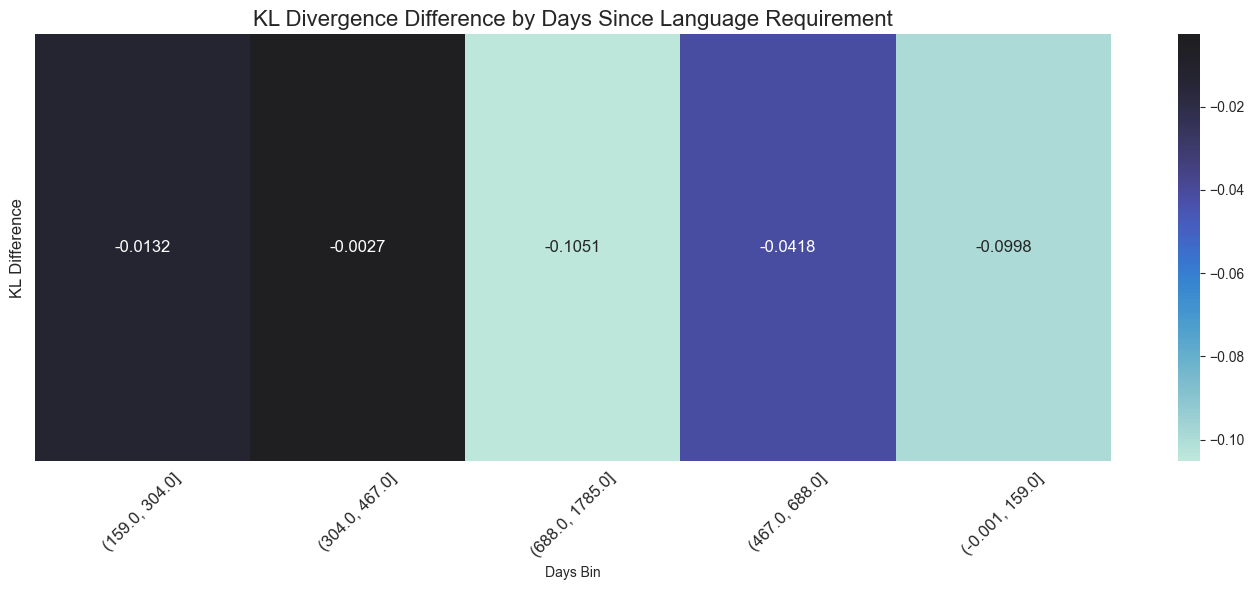

In [22]:
visualize_kl_comparison_heatmap(results)